In [2]:
from hmmlearn.hmm import *
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [4]:
hr_all = pd.read_csv("../data/alpaca_hr.csv")
resp_all = pd.read_csv("../data/alpaca_resp.csv")
sao2_all = pd.read_csv("../data/alpaca_sao2.csv")
gcs_all = pd.read_csv("../data/patient_motor.csv")

hr_all['offset'] /= 60
resp_all['offset'] /= 60
sao2_all['offset'] /= 60
gcs_all['observationoffset'] /= 60

# drop patients with >1 month stay
patients = hr_all.copy()
max_stays = patients.groupby('patientunitstayid').apply(lambda x: x['offset'].max()).values
patients = patients.drop(columns=['offset', 'value']).drop_duplicates()
patients['length_of_stay_hrs'] = max_stays
patients = patients[patients['length_of_stay_hrs'] < 720]
display(patients)

,patientunitstayid,length_of_stay_hrs
0,143274,47.516667
571,144116,69.166667
1402,145997,25.916667
1714,146455,21.583333
1974,147899,126.333333
...,...,...
3499999,3335182,42.200000
3500307,3335520,60.966667
3500461,3339866,41.633333
3500892,3344456,282.716667


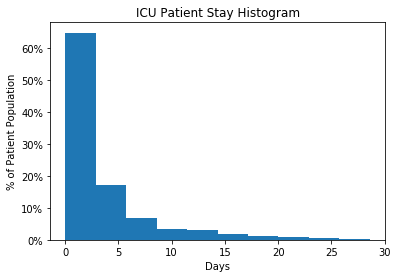

In [5]:
# histogram of patient stay length
plt.hist(patients['length_of_stay_hrs'] / 24, weights=np.ones(len(patients)) / len(patients), bins=10)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("ICU Patient Stay Histogram")
plt.xlabel("Days")
plt.ylabel("% of Patient Population")
plt.show()

In [6]:
# 1 hr bins (consider 2)
binning_interval = 2

In [10]:
hr_all['offset_bin'] = hr_all['offset'] // binning_interval
resp_all['offset_bin'] = resp_all['offset'] // binning_interval
sao2_all['offset_bin'] = sao2_all['offset'] // binning_interval
gcs_all['offset_bin'] = gcs_all['observationoffset'] // binning_interval

hr_binned = patients[['patientunitstayid']].merge(hr_all.drop(columns='offset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index(), how='left')
resp_binned = patients[['patientunitstayid']].merge(resp_all.drop(columns='offset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index(), how='left')
sao2_binned = patients[['patientunitstayid']].merge(sao2_all.drop(columns='offset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index(), how='left')
gcs_binned = patients[['patientunitstayid']].merge(gcs_all.drop(columns='observationoffset').groupby(['patientunitstayid', 'offset_bin']).mean().reset_index(), how='left')

max_bins = patients['length_of_stay_hrs'].max() // binning_interval + 1

# reindex hr df
def rein(df):
    return df.set_index('offset_bin').reindex(np.arange(max_bins))

hr_binned = hr_binned.groupby('patientunitstayid').apply(rein).drop(columns='patientunitstayid').reset_index()

# add key
hr_binned.rename(columns={'value' : 'hr'}, inplace=True)
resp_binned.rename(columns={'value' : 'resp'}, inplace=True)
sao2_binned.rename(columns={'value' : 'sao2'}, inplace=True)
gcs_binned.rename(columns={'Value' : 'gcs'}, inplace=True)

ts_binned = hr_binned.merge(resp_binned, how='left').merge(sao2_binned, how='left').merge(gcs_binned, how='left')
ts_binned = ts_binned.groupby('patientunitstayid').apply(lambda x: x.fillna(method='bfill')).dropna()

#print(ts_binned.groupby('patientunitstayid').apply(lambda x: x['offset_bin'].max()).mean())
#print(ts_binned['offset_bin'].max())
display(ts_binned)

,patientunitstayid,offset_bin,hr,resp,sao2,gcs
10664,172448,0.0,91.391304,14.565217,96.913043,1.0
10665,172448,1.0,92.458333,16.666667,96.000000,1.0
39904,242714,0.0,103.956522,35.586806,94.217391,6.0
39905,242714,1.0,101.083333,35.586806,94.333333,6.0
39906,242714,2.0,100.333333,35.586806,93.458333,6.0
...,...,...,...,...,...,...
1039572,3352819,4.0,77.541667,26.375000,98.833333,6.0
1039573,3352819,5.0,78.208333,27.166667,99.000000,6.0
1039574,3352819,6.0,81.208333,28.708333,98.708333,6.0
1039575,3352819,7.0,84.000000,29.250000,97.395833,6.0


In [29]:
train_patients, test_patients = train_test_split(patients[['patientunitstayid']], test_size=0.2)
ts_binned_train = train_patients.merge(ts_binned)
ts_binned_test = test_patients.merge(ts_binned)

# scale data
scaler = StandardScaler()
ts_binned_train[['hr', 'resp', 'sao2']] = scaler.fit_transform(ts_binned_train[['hr', 'resp', 'sao2']])
ts_binned_test[['hr', 'resp', 'sao2']] = scaler.transform(ts_binned_test[['hr', 'resp', 'sao2']])

# create lists to hold sequences
train_seqs = [ts_binned_train[ts_binned_train['patientunitstayid'] == i].drop(columns=['offset_bin', 'patientunitstayid', 'gcs']).values for i in ts_binned_train['patientunitstayid'].unique()]
train_lens = [x.shape[0] for x in train_seqs]
train_seqs_np = np.vstack(train_seqs)
train_gcs_seq = np.hstack([ts_binned_train['gcs'][ts_binned_train['patientunitstayid'] == i].values for i in ts_binned_train['patientunitstayid'].unique()])

test_seqs = [ts_binned_test[ts_binned_test['patientunitstayid'] == i].drop(columns=['offset_bin', 'patientunitstayid', 'gcs']).values for i in ts_binned_test['patientunitstayid'].unique()]
test_lens = [x.shape[0] for x in test_seqs]
test_seqs_np = np.vstack(test_seqs)
test_gcs_seq = np.hstack([ts_binned_test['gcs'][ts_binned_test['patientunitstayid'] == i].values for i in ts_binned_test['patientunitstayid'].unique()])

print(train_seqs_np.shape)
print(train_lens[0])

(85000, 3)
39


In [30]:
clf = GaussianHMM(n_components=3)
clf.fit(train_seqs_np, lengths=train_lens)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=3, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [31]:
print(clf.startprob_)

[0.49369406 0.22568846 0.28061748]


In [32]:
predicted_seq_train = clf.predict(train_seqs_np, lengths=train_lens)
transformed_means_train = scaler.inverse_transform(clf.means_[predicted_seq_train])
transformed_seq_train = scaler.inverse_transform(train_seqs_np)

#print(clf.means_[0, :, 0].shape)
#print(clf.weights_)
#print(transformed_means_train.shape)
#print(transformed_seq_train.shape)

train_mapes = 100 * np.mean(np.abs(transformed_seq_train - transformed_means_train) / transformed_seq_train, axis=0)

print("Train MAPE (hr): %.2f" % train_mapes[0] + "%", "  \tAD: %.2f" % (transformed_seq_train[:, 0].mean() * train_mapes[0] / 100), "\tstd: %.2f" % transformed_seq_train[:, 0].std())
print("Train MAPE (resp): %.2f" % train_mapes[1] + "%", "\tAD: %.2f" % (transformed_seq_train[:, 1].mean() * train_mapes[1] / 100), "\tstd: %.2f" % transformed_seq_train[:, 1].std())
print("Train MAPE (sao2): %.2f" % train_mapes[2] + "%", "\tAD: %.2f" % (transformed_seq_train[:, 2].mean() * train_mapes[2] / 100), "\tstd: %.2f" % transformed_seq_train[:, 2].std())


predicted_seq_test = clf.predict(test_seqs_np, lengths=test_lens)
transformed_means_test = scaler.inverse_transform(clf.means_[predicted_seq_test])
transformed_seq_test = scaler.inverse_transform(test_seqs_np)

test_mapes = 100 * np.mean(np.abs(transformed_seq_test - transformed_means_test) / transformed_seq_test, axis=0)

print("\nTest MAPE (hr): %.2f" % test_mapes[0] + "%", "  \tAD: %.2f" % (transformed_seq_test[:, 0].mean() * test_mapes[0] / 100), "\tstd: %.2f" % transformed_seq_test[:, 0].std())
print("Test MAPE (resp): %.2f" % test_mapes[1] + "%", "\tAD: %.2f" % (transformed_seq_test[:, 1].mean() * test_mapes[1] / 100), "\tstd: %.2f" % transformed_seq_test[:, 1].std())
print("Test MAPE (sao2): %.2f" % test_mapes[2] + "%", "\tAD: %.2f" % (transformed_seq_test[:, 2].mean() * test_mapes[2] / 100), "\tstd: %.2f" % transformed_seq_test[:, 2].std())

Train MAPE (hr): 11.58%   	AD: 9.85 	std: 17.54
Train MAPE (resp): 19.59% 	AD: 3.87 	std: 5.24
Train MAPE (sao2): 1.54% 	AD: 1.49 	std: 2.68

Test MAPE (hr): 11.49%   	AD: 9.62 	std: 16.93
Test MAPE (resp): 18.84% 	AD: 3.71 	std: 5.34
Test MAPE (sao2): 1.52% 	AD: 1.47 	std: 2.53


In [38]:
# now, evaluate KL-divergence of clusters obtained via HMM

# first get gcs distribution for each cluster
print(predicted_seq_test)
print(test_gcs_seq)

distributions = []

for i in range(clf.n_components):
    dist_i = predicted_seq_test[test_gcs_seq == ]


[0 0 0 ... 2 2 2]
[6. 6. 6. ... 6. 6. 6.]
0
1
2
